## Kernel k-means
In many real-world applications, the assumption that data is linearly separable — as in standard k-means — is too restrictive. Similarly to the objective of PCA, the matrix factorization objective of k-means can be formulated only in dependence of the similarity between data points. This enables the application of the kernel trick. 

### Motivation: Beyond Linear Boundaries
Standard k-means clustering identifies clusters by minimizing the within-cluster variance using Euclidean distances. This inherently restricts the method to discovering linearly separable, convex clusters, since the decision boundary between two centroids is always a hyperplane. But many real-world datasets exhibit complex, nonlinear structures.

For example, suppose we have data distributed in concentric rings or spiral shapes. In such cases, no linear boundary can adequately separate the clusters — standard k-means will fail. An example of the k-means clustering on the two circles dataset is below.

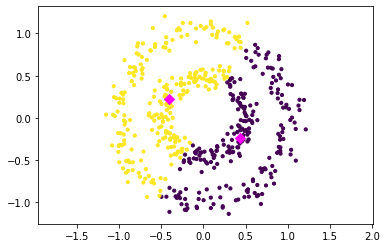

In [1]:
from sklearn.cluster import KMeans
from sklearn import datasets
import matplotlib.pyplot as plt
epsilon=0.08
D, labels = datasets.make_circles(n_samples=500, factor=.5, noise=epsilon)
kmeans = KMeans(n_clusters=2,n_init=1)
kmeans.fit(D)
plt.scatter(D[:, 0], D[:, 1], c=kmeans.labels_, s=10)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='magenta', s=50, marker = 'D')
plt.axis('equal')
plt.show()

### Formalizing the Kernel k-means Objective
Fortunately, the k-means objective has many equivalent objectives, that are basically inherited from the equivalent objectives of the MF problem (compare for example with the PCA section). One of those objectives allows for the application of the kernel trick.

```{prf:theorem} $k$-means trace objective
:label: thm_kmeans_tr
Given a data matrix $D\in\mathbb{R}^{n\times d}$,
the following objectives are equivalent $k$-means objectives:
\begin{align*}
&\min_{Y} \lVert D-YX^\top\rVert^2 \text{  s.t. } X= D^\top Y(Y^\top Y)^{-1}, Y\in\mathbb{1}^{n\times r} \label{eq:km}\\
&\max_{Y} \tr(Z^\top DD^\top Z)\qquad\text{ s.t. } Z= Y(Y^\top Y)^{-1/2}, Y\in\mathbb{1}^{n\times r} 
\end{align*}
```
````{toggle}
```{prf:proof}
For ${\color{magenta}X=D^\top Y(Y^\top Y)^{-1}}$, we have
\begin{align*}
    &\lVert D-Y{\color{magenta}X^\top}\rVert^2 \\
    &= \lVert D\rVert^2 -2\tr(D^\top Y{\color{magenta}X^\top} )+ \lVert Y{\color{magenta}X^\top}\rVert^2 &\text{(binomial formula)}\\
    &= \lVert D\rVert^2 -2\tr(D^\top Y{\color{magenta}X^\top})+ \tr( {\color{magenta}X}Y^\top Y {\color{magenta}X^\top})&\text{(def. Fro-norm by $\tr$)}\\
    &= \lVert D\rVert^2 -2\tr({\color{magenta}X}Y^\top D)+ \tr( {\color{magenta}X}Y^\top Y {\color{magenta}(Y^\top Y)^{-1}Y^\top D})&\text{(def. $X$)}\\
    &= \lVert D\rVert^2 -\tr({\color{magenta}D^\top Y(Y^\top Y)^{-1}}Y^\top D)&\text{($Y^\top Y(Y^\top Y)^{-1} =I$)}\\
    &= \lVert D\rVert^2 -\tr( (Y^\top Y)^{-1/2}Y^\top DD^\top Y (Y^\top Y)^{-1/2})&\text{(cycling property $\tr$)}
\end{align*}
As a result, the objective function of $k$-means is equal to
\begin{align*}
    \lVert D-Y{\color{magenta}X^\top}\rVert^2
    &= \lVert D\rVert^2 -\tr( (Y^\top Y)^{-1/2}Y^\top DD^\top Y (Y^\top Y)^{-1/2})\\
    &=\lVert D\rVert^2 -\tr( (Z^\top DD^\top Z),
\end{align*}
for $Z =Y (Y^\top Y)^{-1/2} $.
Minimizing the term on the left is equivalent to minimizing the negative trace term on the right, which is equivalent to maximizing the trace term on the right.
```
````
The maximum trace objective is formulated only with respect to the inner product similarity between data points, given by the matrix $DD^\top$. That is, the similarity between points with indices $i$ and $j$ are given by
$$sim(i,j) = D_{i\cdot}D_{j\cdot}^\top $$
The trace objective states that points within one cluster are supposed to be similar in the inner product similarity:
$$\tr(Z^\top DD^\top Z)=\sum_{s=1}^r\frac{Y_{\cdot s}^\top DD^\top Y_{\cdot s}}{\lvert Y_{\cdot s}\rvert}
=\sum_{s=1}^r\frac{1}{\lvert \mathcal{C}_{s}\rvert}\sum_{i,j\in\mathcal{C}_s} D_{i\cdot}D_{j\cdot}^\top$$
We can replace the inner product with a kernel function $k:\mathbb{R}^d\times \mathbb{R}^d\rightarrow \mathbb{R}$ being defined over the inner product of a feature transformation $\phi:\mathbb{R}^d\rightarrow \mathbb{R}^p$ where clusters are hopefully linearly separable:
$$k(D_{i\cdot},D_{j\cdot})=\phi(D_{i\cdot})^\top \phi(D_{j\cdot})$$
Defining for $D\in\mathbb{R}^{n\times d}$ the row-wise applied feature transformation
$${\bm\phi}(D)= \begin{pmatrix}--& {\bm\phi}(D_{1\cdot }) & --\\ &\vdots&\\ --&{\bm\phi}(D_{n\cdot})&--\end{pmatrix},$$
the kernel matrix is then given by
$$ K = {\bm\phi}(D){\bm\phi}(D)^\top\in\mathbb{R}^{n\times n}.$$
```{admonition} Task (Kernel k-means)
:class: tip
:name: kernel_kmeans_task
**Given** a kernel matrix $K\in\mathbb{R}^{n\times n}$, and the number of clusters $r$.      
**Find** clusters indicated by the matrix $Y\in\mathbb{1}^{n\times r}$ maximizing the similarities of points within one cluster
\begin{align*}
\max_{Y} \tr(Z^\top K Z)\qquad\text{ s.t. } Z= Y(Y^\top Y)^{-1/2}, Y\in\mathbb{1}^{n\times r} 
\end{align*}
**Return** the clustering $Y\in\mathbb{1}^{n\times r}$
```

### Comparison of Inner Product Similarities
Inner product similarities can be a bit tricky to understand at first. Why do they capture similarity? And what kind of structure do they reveal in the data?     

To build some intuition, we visualize these similarities as a graph: every data point is connected to every other point with an edge, and the thickness of the edge reflects how similar the points are. Specifically, we only show edges with positive similarity to avoid clutter. The thicker the edge, the stronger the similarity.

#### Example 1: Two Blobs     
In the plot of the two blobs dataset below, we can see that the the upper-right cluster appears more tightly connected than the lower-left one. That is because inner product similarity is influenced not just by the direction between two points (like cosine similarity), but also by their norms (lengths). Specifically, we have:
$$sim(i,j) = D_{i\cdot}D_{j\cdot}^\top =\cos(\sphericalangle(D_{i\cdot},D_{j\cdot}))\lVert D_{i\cdot}\rVert\lVert D_{j\cdot}\rVert$$

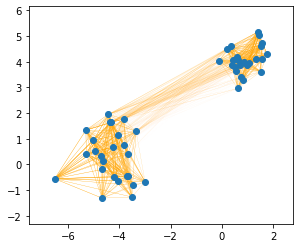

In [2]:
from scipy import sparse
from matplotlib.collections import LineCollection
import numpy as np
epsilon=0.00
D, labels = datasets.make_blobs(n_samples=50,centers=2, cluster_std=[epsilon + 0.5, epsilon + 0.8],random_state=3)

A=D@D.T
A = A/ np.max(A)/2
A *= np.tri(*A.shape)
A*= (A>0)
sA = sparse.csr_matrix(A)
segments = np.concatenate([D[sA.nonzero()[0],:].reshape(-1, 1, 2),D[sA.nonzero()[1],:].reshape(-1, 1, 2)],axis=1)
lc = LineCollection(segments, linewidths=np.array(sA[sA.nonzero()])[0],color='orange')
fig,ax = plt.subplots()

ax.add_collection(lc)
ax.scatter(D[:, 0], D[:, 1],  zorder=10)
ax.set_xlim(np.min(D[:,0])-1, np.max(D[:,0])+1)
ax.set_ylim(np.min(D[:,1])-1, np.max(D[:,1])+1)
ax.set_aspect("equal") 

So even if two pairs of points point in the same direction, the pair with longer vectors will have a larger inner product. This explains why clusters with longer vectors (like the top-right one) appear more strongly connected. As a result, the two blob data can be separated with the inner product similarity, since it's beneficial not to break up the strongly connected cluster on the top right, and hence they get separated.      
#### Example 2: Two Circles    
Next, we look at a two concentric circles dataset. Here, the structure is quite different.

For the two circles dataset (here it's centered) plotted below, we observe that in particular points that the two circles are strongly connected. ALthough points on the outer circle are more strongly connected than points in the inner circle, the points that ar in the same direction are also well connected. This way, it's more beneficial to separate the two circles as one would cut a donut.

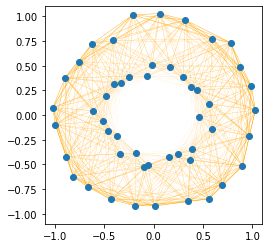

In [3]:
from scipy import sparse
epsilon=0.05
D, labels = datasets.make_circles(n_samples=50, factor=.5, noise=epsilon)

A=D@D.T
A = A/ np.max(A)/2
A *= np.tri(*A.shape)
A*= (A>0)
sA = sparse.csr_matrix(A)
segments = np.concatenate([D[sA.nonzero()[0],:].reshape(-1, 1, 2),D[sA.nonzero()[1],:].reshape(-1, 1, 2)],axis=1)
lc = LineCollection(segments, linewidths=np.array(sA[sA.nonzero()])[0],color='orange')
fig,ax = plt.subplots()

ax.add_collection(lc)
ax.scatter(D[:, 0], D[:, 1],  zorder=10)
ax.set_xlim(-1.1, 1.1)
ax.set_ylim(-1.1, 1.1)
ax.set_aspect("equal") 

The points on the outer circle tend to be more similar to each other because their vectors are longer. However, points on different circles that point into the same direction (lying along the same ray from the origin) have high similarity, since the angle between them is small and one of the points has a high norm and the other has a lower norm. This causes strong connections between the circles, making the inner product similarity graph look more like a "donut" with strong radial connections. If we were to cluster this data based on inner product similarity, we would slice it like a donut into two halves with a (linear) cut of the knife.

### Optimization
To make use of the kernel trick in kernel k-means, we must find a way to optimize the clustering objective without explicitly computing the feature transformation $\bm\phi$ that defines the kernel. This is crucial because many useful kernels (like the RBF kernel) map data into infinite-dimensional spaces, where direct computation is infeasible.
The problem that we face is that we don't know how to optimize the trace objective of the kernel {ref}`Kernel k-means<kernel_kmeans_task>` task directly. According to {prf:ref}`thm_kmeans_tr`, the kernel k-means objective is equivalent to solving k-means in the transformed feature space:
$$\min_{Y} \|{\bm\phi}(D)-YX^\top\|^2 \text{  s.t. } X= {\bm\phi}(D^\top) Y(Y^\top Y)^{-1}, Y\in\mathbb{1}^{n\times r}. $$
In theory, we could apply Lloyd's algorithm directly to the transformed data. However, since we do not (and often cannot) compute $\bm\phi(D)$ explicitly, this direct approach is not viable for most kernels.
#### Idea: Factorize the Kernel
Instead of trying to work with the feature map, we compute a factorization of the kernel in another transformed feature space, that has maximally $n$ dimensions. Since every kernel is a symmetric matrix, because the inner product is symmetric, we can apply the following fundamental result from linear algebra:
```{prf:theorem} Eigendecomposition of symmetric matrices
For every symmetric matrix $K=K^\top\in\mathbb{R}^{n\times n}$ there exists an orthogonal matrix $V\in\mathbb{R}^{n\times n}$ and a diagonal matrix $\Lambda=\diag(\lambda_1,\ldots,\lambda_n)$ where $\lambda_1\geq \ldots \geq \lambda_n$ such that
    $$K=V\Lambda V^\top$$
```
In particular, if all eigenvalues of $K$ are nonnegative, we can write 
$$K=A^\top A$$ 
where $A=V\Lambda^{1/2}$ can be seen as the matrix of embedded feature vectors - a surrogate for $\bm\phi(D)$. This is possible if and only if the eigenvalues of $K$ are nonnegative, which holds for all kernel matrices.

```{prf:corollary} Equivalent kernel $k$-means objectives
Given the kernel matrix $K={\bm\phi}(D){\bm\phi}(D)^\top$,
the following objectives are equivalent:
\begin{align}
&\min_{Y} \|{\bm\phi}(D)-YX^\top\|^2 \text{  s.t. } X= {\bm\phi}(D^\top) Y(Y^\top Y)^{-1}, Y\in\mathbb{1}^{n\times r} \label{eq:kernelKMPhi1}\\
&\max_{Y} \tr(Z^\top K Z)\qquad\text{ s.t. } Z= Y(Y^\top Y)^{-1/2}, Y\in\mathbb{1}^{n\times r} \label{eq:kernelKMtr}
\end{align}
```


We summarize this result in the following corollary.
```{prf:corollary} Equivalent kernel $k$-means objectives
Given a kernel matrix and its symmetric decomposition $K=AA^\top$,
the following objectives are equivalent:
\begin{align}
&\min_{Y}\ \|A-YX^\top\|^2 &\text{ s.t. } X= A^\top Y(Y^\top Y)^{-1}, Y\in\mathbb{1}^{n\times r}\label{eq:kmeansA} \\
&\max_{Y}\ \tr(Z^\top K Z)&\text{ s.t. } Z= Y(Y^\top Y)^{-1/2}, Y\in\mathbb{1}^{n\times r} 
\end{align}
```
Thanks to this result, we now have a way to formulate an algorithm for the kernel k-means task. We compute a symmetric decomposition $AA^\top=K$ by means of the eigendecomposition $A=V\Lambda^{1/2}$ and run $k$-means on $A$.

```{prf:algorithm} kernel k-means

**Input**: kernel matrix $K$, number of clusters $r$
1. $(V,\Lambda) \gets$`Eigendecomposition`$K$
2. $A\gets V\Lambda^{1/2}$ ($AA^\top=K$)
3. $(X,Y)\gets$`kMeans`$(A,r)$    
3. **return** $Y$
```
### Application to the Two Circles Dataset
Let's try the kernel $k$-means idea on the two circles dataset. We use the RBF kernel to reflect similarities between points:
$$K_{ij}=\exp\left(-\epsilon\lVert D_{i\cdot} -D_{j\cdot}\rVert^2\right)$$
The plot below visualizes the RBF similarities of the two-circles dataset. We see in particular that the inner circle is strongly connected. The RBF kernel focuses in particular on local similarities, and in the inner circle, points have the tendency to be more close than points that are in the outer circle.

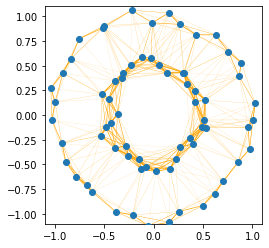

In [4]:
from scipy import sparse
epsilon=0.05
D, labels = datasets.make_circles(n_samples=70, factor=.5, noise=epsilon)

A=np.exp(-8*(np.sum(D**2,1).reshape(-1,1)  - 2* D@D.T + np.sum(D.T**2,0)))
A = A/ np.max(A)
A *= np.tri(*A.shape)
A*= (A>0.08)
sA = sparse.csr_matrix(A)
segments = np.concatenate([D[sA.nonzero()[0],:].reshape(-1, 1, 2),D[sA.nonzero()[1],:].reshape(-1, 1, 2)],axis=1)
lc = LineCollection(segments, linewidths=np.array(sA[sA.nonzero()])[0],color='orange')
fig,ax = plt.subplots()

ax.add_collection(lc)
ax.scatter(D[:, 0], D[:, 1],  zorder=10)
ax.set_xlim(-1.1, 1.1)
ax.set_ylim(-1.1, 1.1)
ax.set_aspect("equal")

We compute the kernel matrix, apply $k$-means on the factor matrix $V\Lambda^{1/2}$ and plot the resulting clustering by means of colored datapoints.  

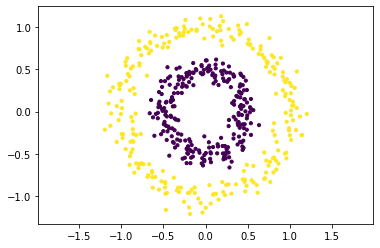

In [5]:
from sklearn.cluster import KMeans
from sklearn import datasets
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import rbf_kernel

D, labels = datasets.make_circles(n_samples=500, factor=.5, noise=0.08)
K= rbf_kernel(D, D,gamma=3)
lambdas, V = np.linalg.eig(K)
kmeans = KMeans(n_clusters=2,n_init=1)
A = np.abs(V)@np.diag(np.abs(lambdas)**(1/2))
kmeans.fit(A)
plt.scatter(D[:, 0], D[:, 1], c=kmeans.labels_, s=10)
plt.axis('equal')
plt.show()

We see that kernel k-means is able to distinguish the two clusters perfectly. We try to get a feeling of the computed embedding defined by $A=V\Lambda^{1/2}$ by plotting the transformed data points in the space spanned by the first two dimensions. That is, on the left you see the points in the original feature space. Points are colored according to the ground truth clustering on the top and according to kernel k-means clustering on the bottom. On the right we see the ground truth clustering in the feature space spanned by $A_{\cdot \{1,2\}}$ at the top, and the k-means clustering at the bottom. The centroids are indicated by diamonds. We can see the clearly linearly separable structure of the two circles in the transformed feature space.

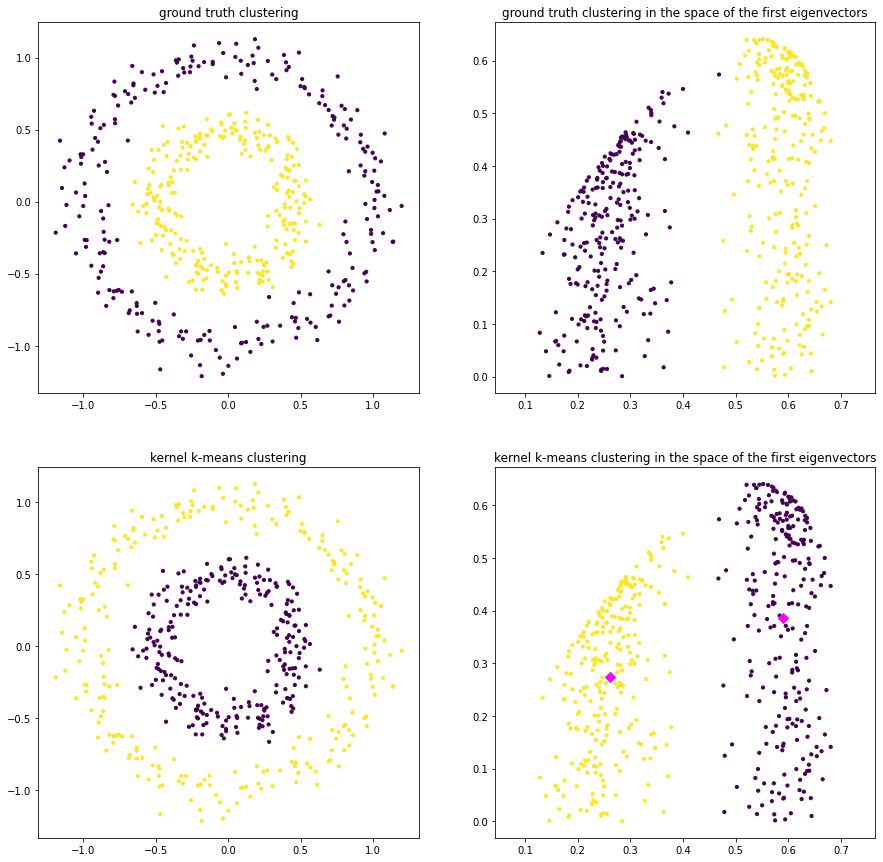

In [6]:
fig = plt.figure(figsize=(15, 15))

plt.subplot(2, 2, 1) 
plt.scatter(D[:, 0], D[:, 1], s=10, c=labels) 
plt.title("ground truth clustering")
plt.axis('equal')

plt.subplot(2, 2, 2)
plt.scatter(A[:, 0], A[:, 1], s=10, c=labels) 
plt.title("ground truth clustering in the space of the first eigenvectors")
plt.axis('equal')

plt.subplot(2, 2, 3)
plt.scatter(D[:, 0], D[:, 1], s=10, c=kmeans.labels_) 
plt.title("kernel k-means clustering")
plt.axis('equal')

plt.subplot(2, 2, 4)
plt.scatter(A[:, 0], A[:, 1], s=10, c=kmeans.labels_) 
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='magenta', s=50, marker = 'D')
plt.title("kernel k-means clustering in the space of the first eigenvectors")
plt.axis('equal')
plt.show()

Ok, so in theory we have a method to solve kernel $k$-means, but in practice this method is not often employed. Drawbacks of kernel $k$-means is a lack of robustness and the requirement of a full eigendecomposition. A related method based on a graph representation of the data facilitates nonconvex clustering based on a truncated eigendecomposition and takes into account results from graph theory to provide a more robust method.